In [20]:
## For data handling
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.notebook import tqdm

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style
set_style("whitegrid")

In [31]:
# Import our data
#data = pd.read_parquet("./combined_data_with_embeddings.parquet")
data = pd.read_parquet("../raw data/combined_data_with_embeddings.parquet")

In [32]:
data

,Text,Label,Model,Original dataset,Row in original dataset,embedding
0,While driverless cars present many promising b...,Machine,darragh_claude_v7,essays,13355,"[0.0044930046, 0.02276886, -0.03793382, 0.0088..."
1,Homework Clubs: The Key to Unlocking Academic ...,Machine,llama2_chat,essays,7249,"[0.0042483085, 0.017574156, -0.010898813, 0.01..."
2,"""The legalization of marijuana has been a cont...",Machine,falcon_180b_v1,essays,2603,"[0.0006997036, -0.008501862, 0.0032627925, -0...."
3,Taking the opportunity to learn new things can...,Machine,mistral7binstruct_v1,essays,3993,"[0.0026538502, 0.0089245895, -0.04195874, -0.0..."
4,Working with a partner is an effective way fo...,Machine,mistral7binstruct_v2,essays,3773,"[0.014354163, 0.01518405, -0.031114087, 0.0014..."
...,...,...,...,...,...,...
79995,The Battle of Lewisham took place on 8 May 180...,Machine,GPT-3 (Curie),wiki,72827,"[-0.007914082, -0.015788127, -0.011993502, 0.0..."
79996,"Asher Wright (September 7, 1803 – April 21, 18...",Machine,GPT-3 (Curie),wiki,106421,"[-0.0071972287, 0.0022026107, -0.030323047, -0..."
79997,LimeWire is a discontinued free software peer-...,Machine,GPT-3 (Curie),wiki,16338,"[-0.012468556, 0.014207671, -0.029412145, 0.00..."
79998,The term Diocese of Canada may refer to: \n\n1...,Machine,GPT-3 (Curie),wiki,53934,"[-0.021509303, -0.028293325, -0.023460228, 0.0..."


In [33]:
data['Model'].value_counts()

Model
Human                                 40000
GPT-3 (Curie)                         10000
GPT-2                                 10000
Grover                                10000
llama2_chat                            1312
mistral7binstruct_v2                   1177
mistral7binstruct_v1                   1145
chat_gpt_moth                          1086
llama_70b_v1                            856
darragh_claude_v6                       827
darragh_claude_v7                       813
falcon_180b_v1                          752
kingki19_palm                           674
palm-text-bison1                        305
cohere-command                          296
radek_500                               253
mistralai/Mistral-7B-Instruct-v0.1      214
NousResearch/Llama-2-7b-chat-hf         186
radekgpt4                               104
Name: count, dtype: int64

In [23]:
# Put embedding coords into separate columns for ease of fitting below
data = pd.concat([data, pd.DataFrame(np.array(data['embedding'].to_list()))], axis = 1)

In [24]:
# Set integer labels
# Human = 0, 1 = Machine
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Human' else 1)

In [25]:
# Train / test split stratified by label and original dataset
data['Label + Dataset'] = data.apply(lambda x:str(x['Label']) + "_" + x['Original dataset'], axis = 1) 
train, test = train_test_split(data, 
                               stratify = data['Label + Dataset'],
                               random_state = 406,
                              train_size = 0.8)

In [26]:
# Metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix

In [27]:
# 5-fold cross validation, stratified by label and original dataset
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 406)

acc_scores = []

for fold, (t_index, v_index) in enumerate(kfold.split(train, train['Label + Dataset'])):
    # Get training x and labels, and validation x and labels
    tt_x = (train.iloc[t_index]).loc[:, 0:1023]
    tt_y = (train.iloc[t_index])['Label']
    vv_x = (train.iloc[v_index]).loc[:, 0:1023]
    vv_y = (train.iloc[v_index])['Label']
    print(f"Fitting fold {fold}")
    xgb = xgboost.XGBClassifier()
    xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
    print(f"Predicting fold {fold}")
    pred = xgb.predict(vv_x)
    acc_scores += [acc(vv_y.values.reshape(-1,1), pred)]

print("Final accuracy scores for each fold:")
print(acc_scores)

Fitting fold 0
Predicting fold 0
Fitting fold 1
Predicting fold 1
Fitting fold 2
Predicting fold 2
Fitting fold 3
Predicting fold 3
Fitting fold 4
Predicting fold 4
Final accuracy scores for each fold:
[0.71484375, 0.711328125, 0.71546875, 0.713984375, 0.7178125]


In [9]:
# xgboost out-of-the-box on full training data
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']
xgb = xgboost.XGBClassifier()
xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
pred = xgb.predict(vv_x)
print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")

Accuracy: 0.72484375


In [11]:
# Brief grid search

estimators = [10, 50, 100, 300, 500]
max_depths = [3, 5, 7]
accuracies = {}
for n_estimators in estimators:
    for max_depth in max_depths:
        xgb = xgboost.XGBClassifier(n_estimators = n_estimators,
                           max_depth = max_depth,
                           random_state = 406)
        xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
        pred = xgb.predict(vv_x)
        print("-----------------------------------------")
        print(f"Using n_estimators={n_estimators}, max_depth={max_depth}")
        print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")
        print(f"Confusion matrix: \n{confusion_matrix(vv_y.values.reshape(-1,1), pred, normalize = 'true')}")

-----------------------------------------
Using n_estimators=10, max_depth=3
Accuracy: 0.638984375
Confusion matrix: 
[[0.68375    0.31625   ]
 [0.40578125 0.59421875]]
-----------------------------------------
Using n_estimators=10, max_depth=5
Accuracy: 0.660078125
Confusion matrix: 
[[0.6928125  0.3071875 ]
 [0.37265625 0.62734375]]
-----------------------------------------
Using n_estimators=10, max_depth=7
Accuracy: 0.669609375
Confusion matrix: 
[[0.681875   0.318125  ]
 [0.34265625 0.65734375]]
-----------------------------------------
Using n_estimators=50, max_depth=3
Accuracy: 0.682734375
Confusion matrix: 
[[0.70953125 0.29046875]
 [0.3440625  0.6559375 ]]
-----------------------------------------
Using n_estimators=50, max_depth=5
Accuracy: 0.70671875
Confusion matrix: 
[[0.72640625 0.27359375]
 [0.31296875 0.68703125]]
-----------------------------------------
Using n_estimators=50, max_depth=7
Accuracy: 0.70328125
Confusion matrix: 
[[0.71890625 0.28109375]
 [0.31234375 0

In [12]:
# xgboost on full training data with many estimators
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']
xgb = xgboost.XGBClassifier(n_estimators = 1500,
                           max_depth = 5,
                           random_state = 406)
xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
pred = xgb.predict(vv_x)
print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")
print(f"Confusion matrix: \n{confusion_matrix(vv_y.values.reshape(-1,1), pred, normalize = 'true')}")

Accuracy: 0.7525
Confusion matrix: 
[[0.76515625 0.23484375]
 [0.26015625 0.73984375]]


In [2]:
import logging
import sys
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [19]:
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']

In [45]:
def objective(trial):

    classifier_name = trial.suggest_categorical('classifier',['RandomForest', 'XGBoost'])
    X = tt.loc[:,0:1023]
    y = tt['Label']
    
    cv_skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    if classifier_name=="RandomForest":
        param = {"n_jobs":30}
        param['max_depth']   = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        param['n_estimators']= trial.suggest_int('rf_n_estimators', 10, 1000, log=True)
        param["max_features"]= trial.suggest_categorical('rf_max_features',['auto', 'sqrt', 'log2'])
        
        classifier_obj = RandomForestClassifier(**param)
    
    if classifier_name=="XGBoost":
        param={"n_jobs":10,
               'eval_metric':'auc',
               'use_label_encoder':False}
        
        param['n_estimators'] = trial.suggest_int('xgb_n_estimators', 10, 1000, log=True)
        param['max_depth']    = trial.suggest_int('xgb_max_depth', 2, 32, log=True)
        param['learning_rate']= trial.suggest_float("xgb_eta", 1e-8, 1.0, log=True)
        param["gamma"]        = trial.suggest_float("xgb_gamma", 1e-8, 1.0, log=True)  
        param['reg_alpha']    = trial.suggest_float("xgb_alpha", 1e-8, 1.0, log=True)
        param['reg_lambda']   = trial.suggest_float("xgb_lambda", 1e-8, 1.0, log=True)
        param['booster']      = trial.suggest_categorical('xgb_booster', ['gbtree', 'gblinear', 'dart'])
    
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        classifier_obj = xgboost.XGBClassifier(**param)
        
        
        
        
    cv_results = cross_validate(estimator=classifier_obj,
                                X=X,
                                y=y,
                                scoring='f1',
                                cv=cv_skf)
    print(param)
    print(cv_results)
    mean_score = cv_results['test_score'].mean()
    return mean_score

In [46]:
study = optuna.create_study(study_name="gfp_dist",
                            direction='maximize',
                            load_if_exists=True,storage="sqlite:///optgfp_dist_tmp.db")

[I 2024-07-19 09:21:52,212] Using an existing study with name 'gfp_dist' instead of creating a new one.


In [47]:
study.optimize(objective, n_trials=10)

[I 2024-07-19 11:46:26,548] Trial 2 finished with value: 0.7152529959586562 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 165, 'xgb_max_depth': 6, 'xgb_eta': 0.10675487326734849, 'xgb_gamma': 0.019924242165140885, 'xgb_alpha': 0.008679744761644364, 'xgb_lambda': 2.4075062769649753e-08, 'xgb_booster': 'dart'}. Best is trial 2 with value: 0.7152529959586562.


{'n_jobs': 10, 'eval_metric': 'auc', 'use_label_encoder': False, 'n_estimators': 165, 'max_depth': 6, 'learning_rate': 0.10675487326734849, 'gamma': 0.019924242165140885, 'reg_alpha': 0.008679744761644364, 'reg_lambda': 2.4075062769649753e-08, 'booster': 'dart'}
{'fit_time': array([1785.82703519, 4418.45309687,  828.90154195,  839.54103613,
        790.95453191]), 'score_time': array([1.91604471, 1.616817  , 1.92711234, 1.64027905, 1.74081993]), 'test_score': array([0.72463768, 0.71692491, 0.71776934, 0.71028222, 0.70665083])}


[W 2024-07-19 11:47:05,033] Trial 3 failed with parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 13, 'xgb_max_depth': 12, 'xgb_eta': 0.11254225997296635, 'xgb_gamma': 5.070646113737883e-07, 'xgb_alpha': 0.10773761183179661, 'xgb_lambda': 3.3298955957393254e-05, 'xgb_booster': 'dart'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/xn/5_bv95hd63q1174827crqlfm0000gn/T/ipykernel_19175/1445551876.py", line 36, in objective
    cv_results = cross_validate(estimator=classifier_obj,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/si

KeyboardInterrupt: 

In [22]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_intermediate_values,plot_parallel_coordinate,plot_param_importances

/var/folders/xn/5_bv95hd63q1174827crqlfm0000gn/T/ipykernel_19175/3040378434.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study=study)
[W 2024-07-19 09:14:09,330] There are no complete trials.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

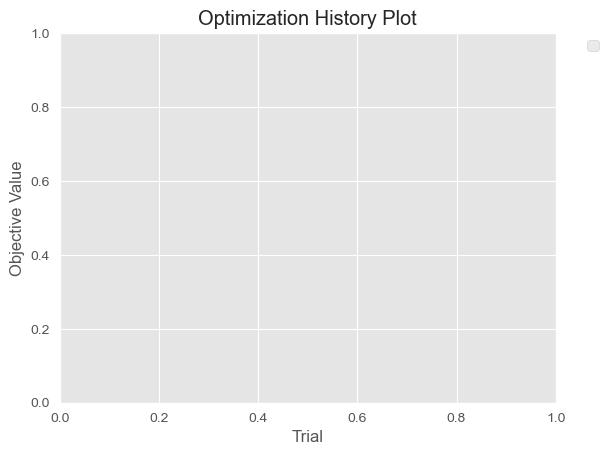

In [23]:
plot_optimization_history(study=study)

In [24]:
study_df = study.trials_dataframe()
study_df.head() 

""


In [ ]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

### Testing accuracies on each type of data

In [28]:
# 5-fold cross validation, stratified by label and original dataset
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 406)

acc_scores = {data_type: [] for data_type in ['essays', 'grover', 'wiki', 'reviews']}

for data_type in ['essays', 'grover', 'wiki', 'reviews']:
    data = train[train['Original dataset'] == data_type]
    for fold, (t_index, v_index) in enumerate(kfold.split(data, data['Label + Dataset'])):
        # Get training x and labels, and validation x and labels
        tt_x = (data.iloc[t_index]).loc[:, 0:1023]
        tt_y = (data.iloc[t_index])['Label']
        vv_x = (data.iloc[v_index]).loc[:, 0:1023]
        vv_y = (data.iloc[v_index])['Label']
        print(f"Fitting fold {fold} for data type {data_type}")
        xgb = xgboost.XGBClassifier()
        xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
        print(f"Predicting fold {fold} for type {data_type}")
        pred = xgb.predict(vv_x)
        fold_acc = acc(vv_y.values.reshape(-1,1), pred)
        print(f"Accuracy: {fold_acc}")
        acc_scores[data_type] += [fold_acc]

print("Final accuracy scores for each fold:")
print(acc_scores)

Fitting fold 0 for data type essays
Predicting fold 0 for type essays
Accuracy: 0.981875
Fitting fold 1 for data type essays
Predicting fold 1 for type essays
Accuracy: 0.976875
Fitting fold 2 for data type essays
Predicting fold 2 for type essays
Accuracy: 0.9784375
Fitting fold 3 for data type essays
Predicting fold 3 for type essays
Accuracy: 0.9796875
Fitting fold 4 for data type essays
Predicting fold 4 for type essays
Accuracy: 0.9853125
Fitting fold 0 for data type grover
Predicting fold 0 for type grover
Accuracy: 0.535
Fitting fold 1 for data type grover


KeyboardInterrupt: 